In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
q = 5e-10 # esu, electron charge
hbar = 1e-27 # erg.s
h_Planck = hbar * 2*np.pi # erg.s
m_e = 1e-27 # g, electron mass
c = 3e10 # cm/s, speed of light
eV2erg = 1.602e-12

In [3]:
L_s = 1e43 # erg/s, supernova luminosity
E_in = 1 * eV2erg # ergs, initial photon energy
nu_in = E_in / h_Planck # Hz, photon frequency
tau = 0.01 # optical depth for shell of relativistic e-
N_p = 1000000 # number of MC packets

L_p = L_s/N_p # erg/s, MC packet luminosity

In [4]:
def calc_PSD(gamma, cos_theta_in, cos_theta_out_p, E_in):
    '''
    Inputs:
        gamma: Scalar or NumPy array of gamma.
        cos_theta_in: Scalar or NumPy array of cos(theta_in).
        cos_theta_out_p: Scalar or NumPy array of cos(theta_out').
        E_in: Ergs, scalar or NumPy array of pre-scattering photon energy.
    Returns:
        nu_out_bin_vec: NumPy array of floats. A collection of frequencies of
            photons after Compton scattering against a relativistic electron.
            These are uniformly spaced in the logarithmic scale.
        PSD: NumPy array of floats. Power spectral density, index matched
            ot nu_out_bin_vec, in erg/(s.Hz).
    Raises:
        A stink if (more than one of gamma, cos_theta_in, cos_theta_out_p, and E_in 
        are NumPy arrays) and (of those which are arrays, the dimensions don't match).
    '''
    beta = np.sqrt(1 - 1/gamma**2)
    E_out_dat = E_in * gamma**2 \
        * (1 - beta*cos_theta_in_dat) \
        * (1 + beta*cos_theta_out_p_dat)
    L_out_dat = L_p * E_out_dat/E_in * (1-np.exp(-tau))
    
    # Binning data and getting counts
#     hist, L_out_bins = np.histogram(L_out_dat, bins=100)
    L_out_bins = np.logspace(np.log10(min(L_out_dat)-.1), 
                             np.log10(max(L_out_dat)+.1),
                             num=100)
    hist,_ = np.histogram(L_out_dat, bins=L_out_bins)

    # Getting x-axis for for-realsies plotting
    L_out_bin_vec = 0.5 * (L_out_bins[1:]+L_out_bins[:-1])
    E_out_bin_vec = L_out_bin_vec/L_p * E_in / (1-np.exp(-tau))
    nu_out_bin_vec = E_out_bin_vec / h_Planck

    # Normalizing by bin width
    L_out_bin_width_vec = L_out_bins[1:] - L_out_bins[:-1]
    E_out_bin_width_vec = L_out_bin_width_vec/L_p * E_in / (1-np.exp(-tau))
    nu_out_bin_width_vec = E_out_bin_width_vec / h_Planck

    PSD = hist * L_out_bin_vec / nu_out_bin_width_vec
    
    return nu_out_bin_vec, PSD

<h2>1</h2>

In [5]:
gamma = 10

# MC setup
np.random.seed(0) # DEBUG constant seed
cos_theta_in_dat = np.random.uniform(-1, 1, N_p)
np.random.seed(1) # DEBUG constant seed
cos_theta_out_p_dat = np.random.uniform(-1, 1, N_p)

In [6]:
nu_out_single, PSD_single = calc_PSD(gamma, 
                                     cos_theta_in_dat, 
                                     cos_theta_out_p_dat,
                                     E_in)

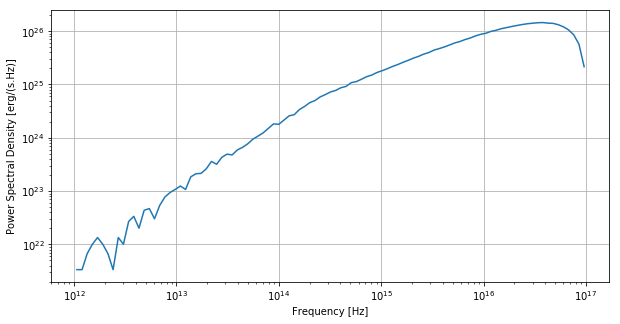

In [7]:
plt.rcParams['figure.figsize'] = (10, 5)
# Plotting
plt.loglog(nu_out_single, PSD_single)
plt.xlabel("Frequency [Hz]");
plt.grid(True)
plt.ylabel("Power Spectral Density [erg/(s.Hz)]");

<h2>2</h2>

In [8]:
gamma_min = 10
gamma_max = 100
p = 2.5
power_law = lambda xmin, xmax, n, size: \
    ((xmax**(n+1) - xmin**(n+1))*np.random.uniform(size=size) \
     + xmin**(n+1)) ** (1/(n+1))

# MC setup
np.random.seed(3) # DEBUG constant seed
gamma_vec = power_law(gamma_min, gamma_max, -p, N_p)

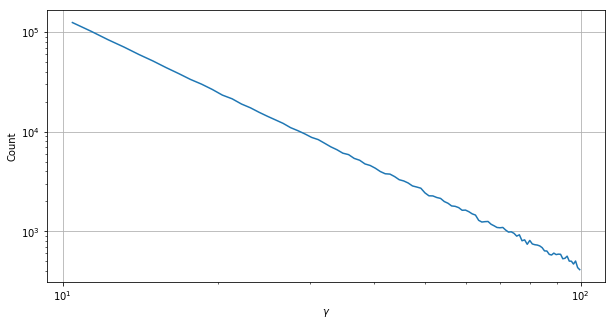

In [9]:
# Sanity checking gamma
gamma_hist, gamma_bins = np.histogram(gamma_vec, bins=100);
plt.loglog(0.5*(gamma_bins[1:]+gamma_bins[:-1]), gamma_hist)
plt.xlabel('$\gamma$')
plt.ylabel('Count')
plt.grid(True)

In [10]:
nu_out_ensemble, PSD_ensemble = calc_PSD(gamma_vec, 
                                         cos_theta_in_dat, 
                                         cos_theta_out_p_dat,
                                         E_in)
nu_out_max, PSD_single_max = calc_PSD(gamma_max,
                                      cos_theta_in_dat,
                                      cos_theta_out_p_dat,
                                      E_in)
nu_out_min, PSD_single_min = calc_PSD(gamma_min,
                                      cos_theta_in_dat,
                                      cos_theta_out_p_dat,
                                      E_in)

In [27]:
# Theory
nu_min = nu_in * gamma_min**2
nu_max = nu_in * gamma_max**2
nu_ensemble_theory = np.logspace(np.log10(nu_min), np.log10(nu_max), 100)

const_A = (1-p) / (gamma_max**(1-p) - gamma_min**(1-p))
dgamma_dnu = 1/(2*np.sqrt(nu_in)) * 1/np.sqrt(nu_ensemble_theory)
dpower_dgamma = N_p * L_p * const_A * (1-np.exp(-tau)) * (nu_ensemble_theory/nu_in)**(1-p/2)
PSD_ensemble_theory = dpower_dgamma * dgamma_dnu

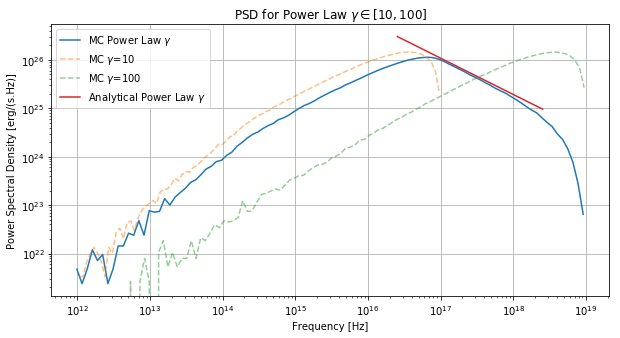

In [28]:
# Plotting
plt.loglog(nu_out_ensemble, PSD_ensemble, label='MC Power Law $\gamma$')
plt.loglog(nu_out_min, PSD_single_min, '--', label=f'MC $\gamma$={gamma_min}', alpha=0.5)
plt.loglog(nu_out_max, PSD_single_max, '--', label=f'MC $\gamma$={gamma_max}', alpha=0.5)
plt.loglog(nu_ensemble_theory, PSD_ensemble_theory, label='Analytical Power Law $\gamma$')
plt.xlabel("Frequency [Hz]");
plt.ylabel("Power Spectral Density [erg/(s.Hz)]");
plt.title('PSD for Power Law $\gamma \in [10,100]$');
plt.grid(True)
plt.legend()